# Import packages and libraries

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# Set the grid

In [2]:
# iB = 6

path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)


In [4]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [5]:
# Copy mskBasin to mymsk
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk <= 8

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mask)  # Count the number of True values in the mask
print(npoints)

67263


In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

LwetC2d 146614
LwetC 4833023



# Load the files

We want the volume transport in and out of the Arctic and to bin this in T-S space

In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [8]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx)) * mymsk[np.newaxis,:,:]
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx)) * mymsk[np.newaxis,:,:]

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [9]:
# get velocity fields
# read timesteps at index 1 and 3
UVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
VVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)-1):

    meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[i+1] + '.meta')
    fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
    varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[0])     # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[1])     # m/s=
    
    # reshaping and fixing up
    UVELMASS[i,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[i,:,:,:] = VVELMASSi.reshape(nz,ny,nx)

# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering=

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo

In [10]:
# load the advection and diffusion terms
# Advection terms for hconv
ADVx_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVy_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFxE_SLT= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFyE_SLT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)   # psu m^3/s
ADVx_TH= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
ADVy_TH= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFxE_TH= np.full((int(len(tsstr)),nz,ny,nx),np.nan)
DFyE_TH = np.full((int(len(tsstr)),nz,ny,nx),np.nan)   # degC m^3/s

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT","ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]
    
    # Vertical Mass-Weighted Comp of Velocity
    ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[0])
    ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[1])
    DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[2])
    DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[3])
    ADVx_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[4])
    ADVy_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[5])
    DFxE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[6])
    DFyE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", read,returnmeta=True,rec = recs[7])


    ADVx_SLT[t] = ADVx_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    ADVy_SLT[t] = ADVy_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFxE_SLT[t] = DFxE_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFyE_SLT[t] = DFyE_SLTi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    ADVx_TH[t] = ADVx_THi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    ADVy_TH[t] = ADVy_THi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFxE_TH[t] = DFxE_THi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]
    DFyE_TH[t] = DFyE_THi.reshape(nz,ny,nx) * mymsk[np.newaxis,:,:]

# Get the gateways and do the TS binning

In [11]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

# binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = np.linspace(-3, 12, 113)
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

coarse_section = np.linspace(0, 28, 20, endpoint=False)
refined_section = np.linspace(28, 40, 93)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)


binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [12]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [13]:
# also bin the time mean of theta
binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
binned_theta_tmean = binned_theta_tmean.astype(float)
binned_theta_tmean[binned_theta_tmean == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)
binned_salinity_tmean = binned_salinity_tmean.astype(float)
binned_salinity_tmean[binned_salinity_tmean == nS] = np.nan

/tmp/ipykernel_34093/497913866.py:2: RuntimeWarning: Mean of empty slice
  binned_theta_tmean = bin_array(np.nanmean(theta,axis=0),binsTH_edges)
/tmp/ipykernel_34093/497913866.py:5: RuntimeWarning: Mean of empty slice
  binned_salinity_tmean = bin_array(np.nanmean(salt,axis=0),binsSLT_edges)


In [14]:
# gates to the Arctic we're interested in:
    # FramStrait
    # CAA
    # BarentsSeaOpening
    # BeringStrait
    # DavisStrait

x1 = gg['FramStrait']["ix"]-1   # 1
y1 = gg['FramStrait']["jy"]-1

x2 = gg['BarentsSeaOpening']["ix"]-1   # 0 
y2 = gg['BarentsSeaOpening']["jy"]-1
x2[x2 == 162] = 161

x3 = gg['CAA']['ix'] -1
y3 = gg['CAA']['jy'] -1

# set Bering Strait manually
x4 = np.array([130,  40, 220, 130,  40, 220, 130,  40, 220, 130,  40, 220, 130,40, 220, 130])
y4 = np.array([813, 814, 814, 815, 816, 816, 817, 818, 818, 819, 820, 820, 821,822, 822, 823])

# set Davis Strait manually
x5 = np.array([ 22, 202, 112,  22, 202, 112,  22, 202, 112,  22, 202, 112,  22,
        202, 112,  22, 202, 112,  22, 202, 112,  22, 202, 112,  22, 202,
        112,  22, 202, 112,  22, 202, 112,  22, 202, 112,  22, 202, 112,
         22])
y5 = np.array([1200, 1201, 1203, 1205, 1206, 1208, 1210, 1211, 1213, 1215, 1216,
        1218, 1220, 1221, 1223, 1225, 1226, 1228, 1230, 1231, 1233, 1235,
        1236, 1238, 1240, 1241, 1243, 1245, 1246, 1248, 1250, 1251, 1253,
        1255, 1256, 1258, 1260, 1261, 1263, 1265])

test = np.full(mskBasin.shape,np.nan)
test[y1,x1] = 1
test[y2,x2] = 2
test[y3,x3] = 3
test[y4,x4] = 4
test[y5,x5] = 5

In [15]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

In [16]:
xs = np.array([x1,x2,x3,x4],dtype="object")
ys = np.array([y1,y2,y3,y4],dtype="object")

# do a sample gateway as a TS mesh

In [17]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
# cmap = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [18]:
# get time mean of velocity
Uomean = np.nanmean(Uo, axis = 0)
Vomean = np.nanmean(Vo, axis = 0)

Uomeancompact = aste_tracer2compact(Uomean,nfx,nfy)
Vomeancompact = aste_tracer2compact(Vomean,nfx,nfy)

/tmp/ipykernel_34093/1847538992.py:2: RuntimeWarning: Mean of empty slice
  Uomean = np.nanmean(Uo, axis = 0)
/tmp/ipykernel_34093/1847538992.py:3: RuntimeWarning: Mean of empty slice
  Vomean = np.nanmean(Vo, axis = 0)


In [19]:
# try to plot on this the advection arrows
ADVy_TH_mean = np.nanmean(ADVy_TH,axis=0)
ADVy_SLT_mean = np.nanmean(ADVy_SLT,axis=0)
ADVx_TH_mean = np.nanmean(ADVx_TH,axis=0)
ADVx_SLT_mean = np.nanmean(ADVx_SLT,axis=0)

/tmp/ipykernel_34093/186832313.py:2: RuntimeWarning: Mean of empty slice
  ADVy_TH_mean = np.nanmean(ADVy_TH,axis=0)
/tmp/ipykernel_34093/186832313.py:3: RuntimeWarning: Mean of empty slice
  ADVy_SLT_mean = np.nanmean(ADVy_SLT,axis=0)
/tmp/ipykernel_34093/186832313.py:4: RuntimeWarning: Mean of empty slice
  ADVx_TH_mean = np.nanmean(ADVx_TH,axis=0)
/tmp/ipykernel_34093/186832313.py:5: RuntimeWarning: Mean of empty slice
  ADVx_SLT_mean = np.nanmean(ADVx_SLT,axis=0)


In [104]:
# try to plot on this the advection arrows
DFyE_TH_mean = np.nanmean(DFyE_TH,axis=0)
DFyE_SLT_mean = np.nanmean(DFyE_SLT,axis=0)
DFxE_TH_mean = np.nanmean(DFxE_TH,axis=0)
DFxE_SLT_mean = np.nanmean(DFxE_SLT,axis=0)

/tmp/ipykernel_34093/122751787.py:2: RuntimeWarning: Mean of empty slice
  DFyE_TH_mean = np.nanmean(DFyE_TH,axis=0)
/tmp/ipykernel_34093/122751787.py:3: RuntimeWarning: Mean of empty slice
  DFyE_SLT_mean = np.nanmean(DFyE_SLT,axis=0)
/tmp/ipykernel_34093/122751787.py:4: RuntimeWarning: Mean of empty slice
  DFxE_TH_mean = np.nanmean(DFxE_TH,axis=0)
/tmp/ipykernel_34093/122751787.py:5: RuntimeWarning: Mean of empty slice
  DFxE_SLT_mean = np.nanmean(DFxE_SLT,axis=0)


In [53]:
y_curr,x_curr = y1,x1
gateid = 1

# get the u and v components
uvelgate = Uomeancompact[:,y_curr,x_curr]
vvelgate = Vomeancompact[:,y_curr,x_curr]

# get the perpendicular vel
mygate = np.where(get_aste_tracer(test,nfx,nfy)[0] ==gateid)
choose_UV = line_orientation(mygate[1],mygate[0])
choose_UV = np.tile(choose_UV,(nz,1))

# calculate transport velocity
perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
for i in range(len(choose_UV)):
    if choose_UV[i][0] == "V":
        perpendicular_vel[i] = uvelgate[i]       # remember to think about proper sign
    elif choose_UV[i][0] == "H":
        perpendicular_vel[i] = vvelgate[i]

# calculate cell area
gatemask = mygrid['hFacC'][:,y_curr,x_curr]
dxggate = mygrid['DXG'][y_curr,x_curr]
dyggate = mygrid['DYG'][y_curr,x_curr]
cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
for i in range(len(choose_UV[0])):
    if choose_UV[0][i] == "V":
        cell_lengths[i] = dyggate[i] #DYG
    elif choose_UV[0][i] == "H":
        cell_lengths[i] = dxggate[i] #DXG
cell_lengths = np.tile(cell_lengths,(nz,1))
cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)

# calculate binned S and T
binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]

data = perpendicular_vel*cell_area*1e-6

# data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]

# get the distribution of volume in TS space
distr = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distr[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += data[i,j]
            #print(distr[int(gate_thetabins[i,j]),int(gate_saltbins[i,j])])


In [54]:
ADVy_TH_gate = ADVy_TH_mean[:,y1,x1]      # degC m^3/s
ADVy_SLT_gate = ADVy_SLT_mean[:,y1,x1]    # PSU m^3/s

# bin these as per the values in the binnedsalt and theta
distrADVy_TH = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrADVy_TH[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += ADVy_TH_gate[i,j]

distrADVy_SLT = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrADVy_SLT[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += ADVy_SLT_gate[i,j]

In [55]:
distrADVy_TH /= np.tile(binwidthT, (112, 1))
distrADVy_SLT /= np.tile(binwidthS, (112, 1))

# replace 0 values with nan
distrADVy_TH[distrADVy_TH == 0 ] = np.nan
distrADVy_SLT[distrADVy_SLT == 0 ] = np.nan

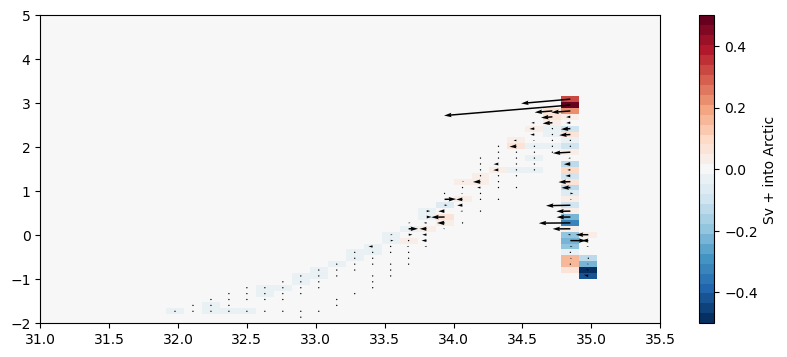

In [56]:
plt.pcolormesh(Sbin,Tbin,distr,cmap=cmap,vmin=-.5,vmax=.5)
plt.ylim(-2,5)
plt.xlim(31,35.5)
plt.colorbar(label="Sv + into Arctic")
plt.quiver(Sbincent,Tbincent,distrADVy_SLT,distrADVy_TH,scale=1000000000)

plt.savefig(path + "FramTransp.png",dpi=300)

# try to loop and plot distr for all gates

1
2
3
4


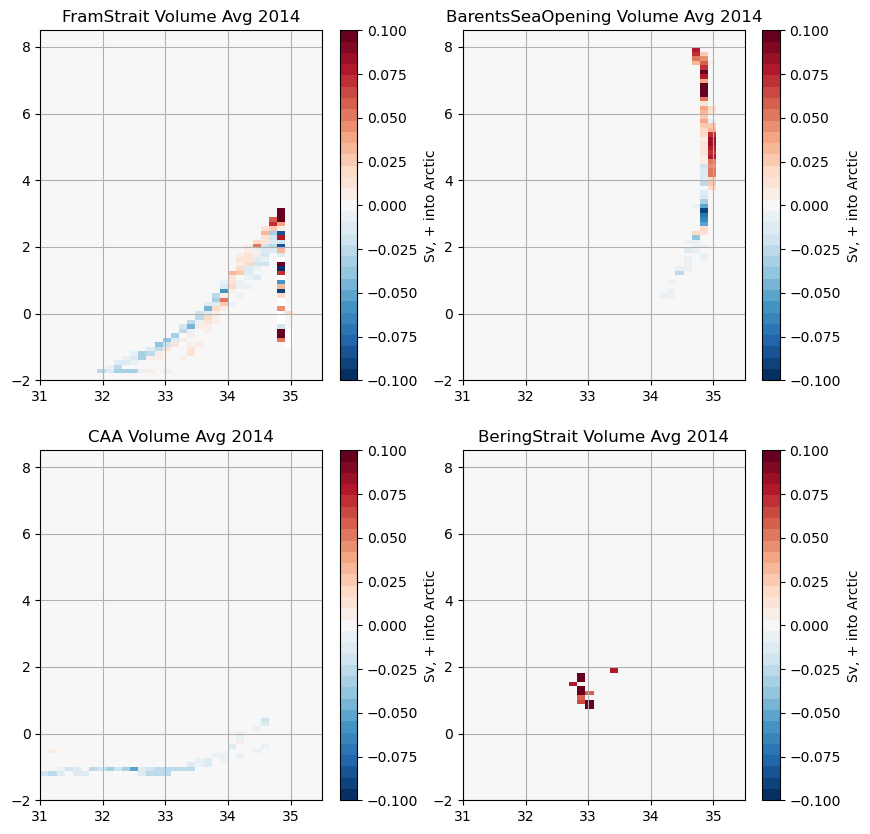

In [57]:
y_curr,x_curr = y1,x1
gateids = np.array([1,2,3,4])
names = np.array(["FramStrait","BarentsSeaOpening","CAA","BeringStrait"])

# loop through each of the gates
fig = plt.figure(figsize=(10,10))
totaldistr = np.full((nT,nS),0.0)

for x_curr, y_curr,gateid,name in zip(xs,ys,gateids,names):
    print(gateid)
    ax = plt.subplot(2,2,gateid)

    # get the u and v components
    uvelgate = Uomeancompact[:,y_curr,x_curr]
    vvelgate = Vomeancompact[:,y_curr,x_curr]
    
    # get the perpendicular vel
    mygate = np.where(get_aste_tracer(test,nfx,nfy)[0] ==gateid)
    choose_UV = line_orientation(mygate[1],mygate[0])
    choose_UV = np.tile(choose_UV,(nz,1))
    
    # calculate transport velocity
    perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
    for i in range(len(choose_UV)):
        if choose_UV[i][0] == "V":
            perpendicular_vel[i] = uvelgate[i]       # remember to think about proper sign
        elif choose_UV[i][0] == "H":
            if name == "BeringStrait":
                perpendicular_vel[i] = -vvelgate[i]
            else:
                perpendicular_vel[i] = vvelgate[i]
    
    # calculate cell area
    gatemask = mygrid['hFacC'][:,y_curr,x_curr]
    dxggate = mygrid['DXG'][y_curr,x_curr]
    dyggate = mygrid['DYG'][y_curr,x_curr]
    cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
    for i in range(len(choose_UV[0])):
        if choose_UV[0][i] == "V":
            cell_lengths[i] = dyggate[i] #DYG
        elif choose_UV[0][i] == "H":
            cell_lengths[i] = dxggate[i] #DXG
    cell_lengths = np.tile(cell_lengths,(nz,1))
    cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)
    
    # calculate binned S and T
    binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
    binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]
    
    data = perpendicular_vel*cell_area*1e-6
    
    # data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
    gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
    gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]
    
    # get the distribution of volume in TS space
    distr = np.full((nT,nS),0.0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(gate_thetabins[i,j]):
                distr[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += data[i,j]

    totaldistr += distr

    cb = ax.pcolormesh(Sbin,Tbin,distr,cmap=cmap,vmin=-.1,vmax=.1)
    ax.set_ylim(-2,8.5)
    ax.set_xlim(31,35.5)
    ax.set_title(name+" Volume Avg 2014")
    plt.colorbar(cb,label="Sv, + into Arctic")
    ax.grid()

plt.savefig(path + "fourgates_TSdist.png",dpi=300)

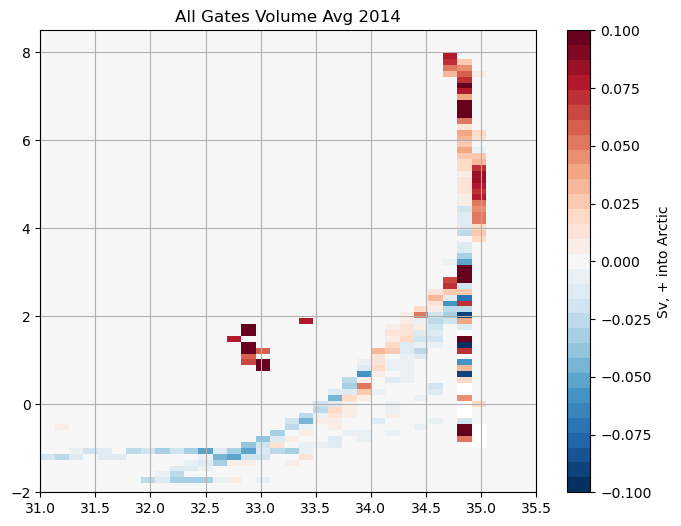

In [58]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
ax.grid()

plt.savefig(path + "pemberton_fig11_total.png",dpi=300)

# Try again

In [78]:
y_curr,x_curr = y3,x3
gateid = 3

# calculate binned S and T
binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]

# data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]

In [79]:
ADVy_TH_gate = ADVx_TH_mean[:,y_curr,x_curr]      # degC m^3/s
ADVy_SLT_gate = ADVx_SLT_mean[:,y_curr,x_curr]    # PSU m^3/s

# bin these as per the values in the binnedsalt and theta
distrADVy_TH = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrADVy_TH[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += ADVy_TH_gate[i,j]

distrADVy_SLT = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrADVy_SLT[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += ADVy_SLT_gate[i,j]

In [80]:
distrADVy_TH /= np.tile(binwidthT, (112, 1))
distrADVy_SLT /= np.tile(binwidthS, (112, 1))

# replace 0 values with nan
# distrADVy_TH[distrADVy_TH == 0 ] = np.nan
# distrADVy_SLT[distrADVy_SLT == 0 ] = np.nan

In [81]:
tot_dist_th += distrADVy_TH
tot_dist_slt += distrADVy_SLT

In [83]:
tot_dist_th[tot_dist_th == 0 ] = np.nan
tot_dist_slt[tot_dist_slt == 0 ] = np.nan

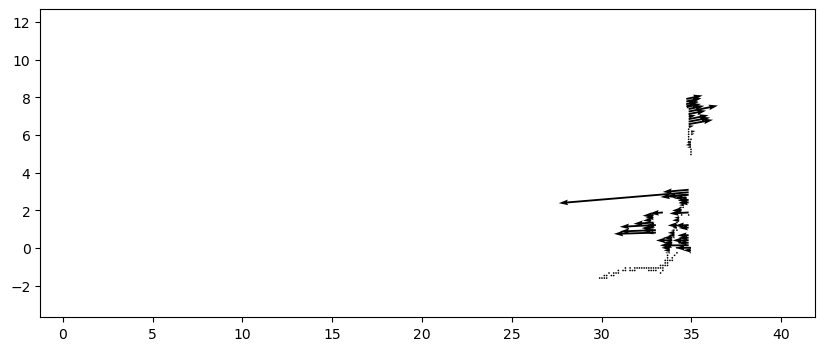

In [84]:
# plt.pcolormesh(Sbin,Tbin,distr,cmap=cmap,vmin=-.5,vmax=.5)
# plt.ylim(-2,5)
# plt.xlim(31,35.5)
# plt.colorbar(label="Sv + into Arctic")
plt.quiver(Sbincent,Tbincent,tot_dist_slt,tot_dist_th,scale=1000000000)

# plt.savefig(path + "FramTransp.png",dpi=300)

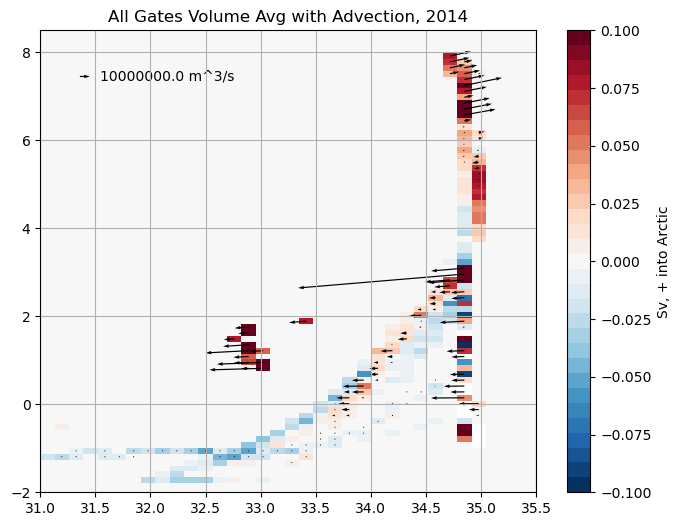

In [102]:
# now plot this on top of the volume distribution totals
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg with Advection, 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
quiver_plot = plt.quiver(Sbincent,Tbincent,tot_dist_slt,tot_dist_th,scale=500000000)

# Add a quiver key (reference arrow)
scale_arrow_magnitude = 1e7  # Adjust this value based on your data's scale
plt.quiverkey(quiver_plot, X=0.1, Y=0.9, U=scale_arrow_magnitude, label=f'{scale_arrow_magnitude} m^3/s', labelpos='E')

ax.grid()

plt.savefig(path + "pemberton_fig12.png",dpi=300)

In [131]:
# let's do the same for diffusion
y_curr,x_curr = y3,x3
gateid = 3

# calculate binned S and T
binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]

# data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]

DFyE_TH_gate = DFxE_TH_mean[:,y_curr,x_curr]      # degC m^3/s
DFyE_SLT_gate = DFxE_SLT_mean[:,y_curr,x_curr]    # PSU m^3/s

# bin these as per the values in the binnedsalt and theta
distrDFyE_TH = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrDFyE_TH[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += -DFyE_TH_gate[i,j]

distrDFyE_SLT = np.full((nT,nS),0.0)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(gate_thetabins[i,j]):
            distrDFyE_SLT[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += -DFyE_SLT_gate[i,j]

distrDFyE_TH /= np.tile(binwidthT, (112, 1))
distrDFyE_SLT /= np.tile(binwidthS, (112, 1))

In [132]:
tot_dist_th_df += distrDFyE_TH
tot_dist_slt_df += distrDFyE_SLT

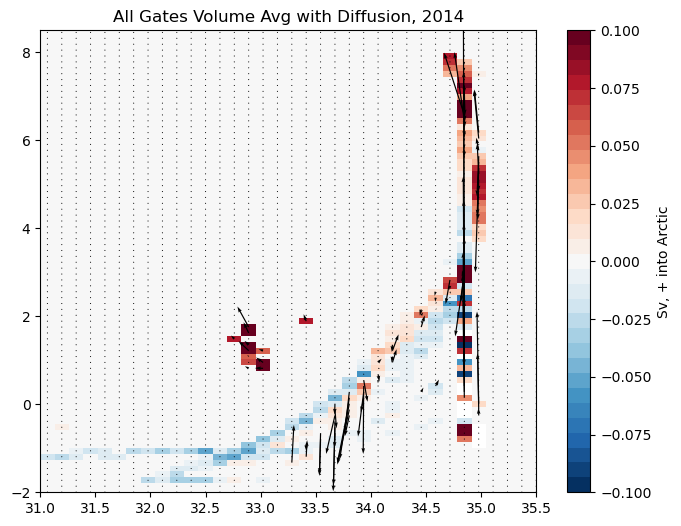

In [138]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg with Diffusion, 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
quiver_plot = plt.quiver(Sbincent,Tbincent,tot_dist_slt_df,tot_dist_th_df,scale=200000)

plt.savefig(path + "pemberton_fig12_diff.png",dpi=300)

In [146]:
tot_dist_slt = np.nan_to_num(tot_dist_slt,nan=0)
tot_dist_th = np.nan_to_num(tot_dist_th,nan=0)

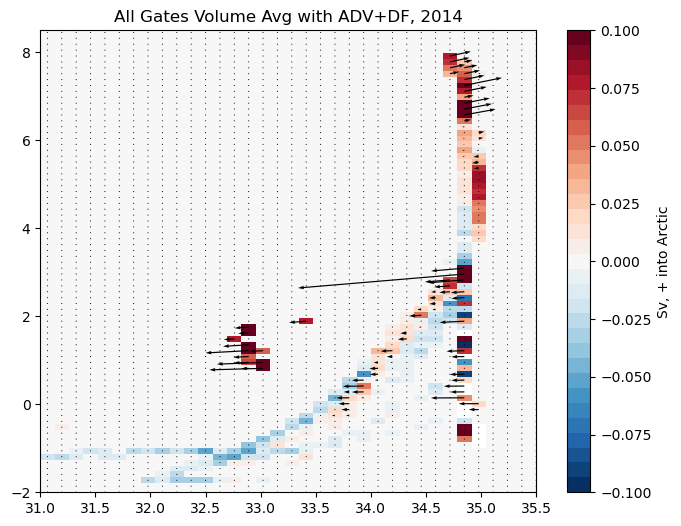

In [154]:
# plot the sum of advection + diffusion for the gates

fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg with ADV+DF, 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
quiver_plot = plt.quiver(Sbincent,Tbincent,tot_dist_slt_df + tot_dist_slt,tot_dist_th_df + tot_dist_th,scale=500000000)

plt.savefig(path + "pemberton_fig12_advplusdiff.png",dpi=300)